In [1]:
from enum import EnumType, Enum

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from pettingzoo.mpe import simple_speaker_listener_v4

def make_env():
    env = simple_speaker_listener_v4.parallel_env(continuous_actions=False, render_mode="rgb_array", max_cycles=25)
    env.reset()
    return env

def make_env_human():
    env = simple_speaker_listener_v4.parallel_env(continuous_actions=False, render_mode="human", max_cycles=25)
    env.reset()
    return env

# Test the environment
env = make_env()
print("Agents:", env.agents)  # ['speaker_0', 'listener_0']

Agents: ['speaker_0', 'listener_0']


In [2]:
class DiscType(Enum):
    DECENTRALIZED = "decentralized"
    CENTRALIZED = "centralized"
    SINGLE = "single"

In [3]:
env.state()
# env.action_space

array([ 0.15      ,  0.65      ,  0.15      ,  0.        ,  0.        ,
       -0.21618372,  0.8076288 ,  1.0865692 , -0.29361886,  0.7403638 ,
        0.8244331 ,  0.        ,  0.        ,  0.        ], dtype=float32)

# Hyperparameters

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

DISC_TYPE = DiscType.CENTRALIZED

num_expert_episodes = 50
# Agent dimensions
speaker_obs_dim = 3     #[goal_id]
listener_obs_dim = 11 #[self_vel, all_landmark_rel_positions, communication]

speaker_act_dim = 3
listener_act_dim = 5 # [no_action, move_left, move_right, move_down, move_up]

# Two layers network, applied for discriminator, policy and value network
all_hid_dim = 128

all_agents = env.agents

obs_dims = {
    "speaker_0": speaker_obs_dim,
    "listener_0": listener_obs_dim
}

act_dims = {
    "speaker_0": speaker_act_dim,
    "listener_0": listener_act_dim
}

hid_dims = {
    "speaker_0": all_hid_dim,
    "listener_0": all_hid_dim
}

# Evaluated from 5000 expert episodes
expert_mean_reward = -39.53

training_epochs = 1000



# Expert Demonstrations
Load the expert policy from paper Inverse Factorized Soft Q-Learning for Cooperative Multi-agent Imitation Learning


In [5]:
env = make_env()

In [6]:
# Load the expert policy
expert_policies = torch.jit.load("Expert_data/simple_speaker_listener.pt").to(device)
expert_policies.eval()

# Try to retrieve h_dim from the policy, fallback to 128
try:
    h_dim = expert_policies.h_dim
    print(f"Retrieved h_dim: {h_dim}")
except AttributeError:
    h_dim = 128  # From error message
    print("h_dim not accessible, using 128")

def expert_policy(obs, rnn_actor, deterministic=True):
    with torch.no_grad():
        # Convert observations to tensors
        obs_speaker = torch.FloatTensor(obs["speaker_0"]).to(device)
        obs_listener = torch.FloatTensor(obs["listener_0"]).to(device)
        # Pad speaker's observation (3) to match listener’s (11)
        obs_speaker_padded = torch.nn.functional.pad(obs_speaker, (0, 11 - 3))
        obs_batch = torch.stack([obs_speaker_padded, obs_listener], dim=0)

        # Define masks and available actions
        masks = torch.ones((2, 1), dtype=torch.bool, device=device)  # For 2 agents
        avails = torch.ones((2, 5), dtype=torch.float32, device=device)  # Assuming 5 actions per agent

        # Forward pass through the policy
        actions, _, new_rnn_actor = expert_policies._forward(
            obs_batch, rnn_actor, masks, avails, deterministic
        )
        actions_dict = {
            "speaker_0": actions[0].item(),
            "listener_0": actions[1].item()
        }
        return actions_dict, new_rnn_actor

def generate_expert_data_decentralized(num_episodes=50):
    env = make_env()  # Assuming this is defined elsewhere

    # TODO should change the data structure to actually store tuple (s,a)
    expert_data = {agent: {"states": [], "actions": []} for agent in env.agents}

    for _ in range(num_episodes):
        obs, _ = env.reset()
        # Initialize rnn_actor with shape (n_agents, 1, h_dim) on device
        rnn_actor = torch.zeros((2, 1, h_dim), device=device)

        while env.agents:
            actions, rnn_actor = expert_policy(obs, rnn_actor, deterministic=True)
            for agent in env.agents:
                expert_data[agent]["states"].append(obs[agent])
                expert_data[agent]["actions"].append(actions[agent])
                joint_state = env.state()
            obs, rewards, terminations, truncations, infos = env.step(actions)

    env.close()
    return expert_data

def convert_decentralized_data_to_centralized(decentralized_data):
    """
    Converts decentralized expert data to centralized format.

    Args:
        decentralized_data (dict): Decentralized expert data with the structure:
            {
                agent1: {"states": [state1, state2, ...], "actions": [action1, action2, ...]},
                agent2: {"states": [state1, state2, ...], "actions": [action1, action2, ...]},
                ...
            }
    Returns:
        dict: Centralized expert data with the structure:
            {
                "global_states": [state1, state2, ...],
                "joint_actions": [actions1, actions2, ...],
            }
    """
    centralized_expert_data = {
        "joint_states": [],  # Global states across all agents
        "joint_actions": []   # Joint actions per global state
    }

    # Ensure we use the same length throughout agents
    num_samples = len(decentralized_data[all_agents[0]]["states"])  # Extract the length from first agent

    for i in range(num_samples):
        # Combine states of all agents into a global state
        global_state = []
        for agent in decentralized_data:
            global_state.extend(decentralized_data[agent]["states"][i])
        centralized_expert_data["joint_states"].append(global_state)

        # Collect actions from all agents into a joint action
        joint_action = [decentralized_data[agent]["actions"][i] for agent in decentralized_data]
        centralized_expert_data["joint_actions"].append(joint_action)

    return centralized_expert_data


Retrieved h_dim: 128


In [7]:
# Generate data
decentralized_expert_data = generate_expert_data_decentralized(num_episodes=num_expert_episodes)

if DISC_TYPE == DiscType.CENTRALIZED:
    centralized_expert_data = convert_decentralized_data_to_centralized(decentralized_expert_data)


In [8]:
decentralized_expert_data["speaker_0"]["states"][0]

array([0.15, 0.15, 0.65], dtype=float32)

In [9]:
decentralized_expert_data["listener_0"]["states"][0]

array([ 0.        ,  0.        , -1.343874  ,  0.58778435, -0.93518203,
       -0.09753238, -0.971888  , -0.06724679,  0.        ,  0.        ,
        0.        ], dtype=float32)

In [10]:
centralized_expert_data = convert_decentralized_data_to_centralized(decentralized_expert_data)
centralized_expert_data["joint_states"][0]

[np.float32(0.15),
 np.float32(0.15),
 np.float32(0.65),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(-1.343874),
 np.float32(0.58778435),
 np.float32(-0.93518203),
 np.float32(-0.09753238),
 np.float32(-0.971888),
 np.float32(-0.06724679),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0)]

Shape Checking

In [11]:
if DISC_TYPE == DiscType.CENTRALIZED:
    expert_states = torch.FloatTensor(centralized_expert_data["joint_states"]).to(device)
    expert_actions = torch.LongTensor(centralized_expert_data["joint_actions"]).to(device)
elif DISC_TYPE == DiscType.DECENTRALIZED:
    agent = "speaker_0"
    expert_states = torch.FloatTensor(decentralized_expert_data[agent]["states"]).to(device)
    expert_actions = torch.LongTensor(decentralized_expert_data[agent]["actions"]).to(device)


In [12]:
expert_states.shape

torch.Size([1250, 14])

In [13]:
expert_actions.shape

torch.Size([1250, 2])

### Evaluate the Expert Policy

In [14]:
import torch
import numpy as np

def evaluate_policy_for_expert(policy_func, num_episodes=50, threshold=0.1, h_dim=128, device=device):
    env = make_env()
    avg_rewards = []

    for episode in range(num_episodes):
        obs, _ = env.reset()
        total_reward = 0
        rnn_actor = torch.zeros((2, 1, h_dim), device=device)

        while env.agents:
            actions, rnn_actor = policy_func(obs, rnn_actor, deterministic=True)
            obs, rewards, done, _, _ = env.step(actions)
            total_reward += sum(rewards.values())

        avg_rewards.append(total_reward)

    env.close()
    return {
        "avg_reward": np.mean(avg_rewards),
    }


In [15]:
# Evaluate the expert policy
expert_eval = evaluate_policy_for_expert(expert_policy, num_episodes=20)
print("Expert Policy Evaluation:", expert_eval)


Expert Policy Evaluation: {'avg_reward': np.float64(-35.317061296761)}


# Policy Evaluation Function

In [16]:
def learned_policy(policies, obs, device=device):
    """
    Retrieves actions from the learned policy networks for both agents based on observations.

    Args:
        policies (dict): Dictionary mapping agent names to their Policy network instances.
        obs (dict): Dictionary of observations for each agent.
        device (str): Device to perform computations on ("cuda:0" or "cpu").

    Returns:
        dict: Dictionary mapping agent names to selected actions.
    """
    actions = {}
    for agent in obs:
        policy = policies[agent]
        # Convert observation to tensor and move to device
        obs_tensor = torch.FloatTensor(obs[agent]).to(device)
        with torch.no_grad():
            # Get action probabilities from the policy network
            action_probs = policy(obs_tensor)
            # Select the action with the highest probability
            action = torch.argmax(action_probs).item()
        actions[agent] = action
    return actions

def evaluate_policy_for_training(policies, num_episodes=50, threshold=0.1, device=device):
    """
    Evaluates the performance of learned policies over multiple episodes.

    Args:
        policies (dict): Dictionary of Policy networks for each agent.
        num_episodes (int): Number of episodes to run for evaluation (default: 50).
        threshold (float): Distance threshold to determine success (default: 0.1).
        device (str): Device to perform computations on (default: "cuda:0" or "cpu").

    Returns:
        dict: Dictionary containing evaluation metrics:
              - "success_rate": Mean success rate across episodes.
              - "avg_reward": Mean total reward per episode.
              - "avg_steps": Mean number of steps per episode.
    """
    # Set to evaluation mode to switch off dropout
    for policy in policies.values():
        policy.eval()

    # Initialize the environment
    env = make_env()
    avg_rewards = []

    # Run evaluation over specified number of episodes
    for episode in range(num_episodes):
        obs, _ = env.reset()
        total_reward = 0

        # Run the episode
        while env.agents:
            # Get actions using the learned policy
            actions = learned_policy(policies, obs, device)
            # Step the environment
            obs, rewards, done, _, _ = env.step(actions)
            total_reward += sum(rewards.values())  # Sum rewards from both agents

        avg_rewards.append(total_reward)

    # Clean up environment resources
    env.close()

    # Compute and return average metrics
    return {
        "avg_reward": np.mean(avg_rewards),
    }

# MAGAIL Training

## Define MAGAIL Networks

In [17]:
import torch
import torch.nn as nn

# Policy Networks (one per agent)
class Policy(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, act_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        return self.net(x)

# Discriminator Networks (one per agent)
# Output the probability of (s,a) Coming from the EXPERT
class Discriminator(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid())
    
    def forward(self, state, action):
        return self.net(torch.cat([state, action], dim=-1))
    
# Value Network as baseline
class ValueNet(nn.Module):
    def __init__(self, obs_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.net(x)


# Initialize Networks 

if DISC_TYPE == DiscType.CENTRALIZED:
    # For Discriminator the output is a single value
    joint_state_dim = sum(obs_dims.values())  # Global state dimension
    joint_action_dim = sum(act_dims.values())
    discriminator_centralized = Discriminator(obs_dim=joint_state_dim, act_dim=joint_action_dim, hidden_dim=hid_dims[all_agents[0]]).to(device)

elif DISC_TYPE == DiscType.DECENTRALIZED:
    discriminators = {
        a: Discriminator(obs_dim=obs_dims[a], act_dim=act_dims[a], hidden_dim=hid_dims[a]).to(device)
        for a in all_agents
    }

# Initialize value networks to reduce variance (actor critic)

policies = {
    a: Policy(obs_dim=obs_dims[a], act_dim=act_dims[a], hidden_dim=hid_dims[a]).to(device)
    for a in all_agents
}

# Replace the original value_nets initialization with:
if DISC_TYPE == DiscType.CENTRALIZED:
    joint_state_dim = sum(obs_dims.values())  # Global state dimension
    value_nets = {}
    for agent in all_agents:
        value_nets[agent] = ValueNet(joint_state_dim, hid_dims[agent]).to(device)
elif DISC_TYPE == DiscType.DECENTRALIZED:
    value_nets = {
        agent: ValueNet(obs_dims[agent], hid_dims[agent]).to(device)
        for agent in all_agents
    }

In [18]:
sum(act_dims.values())

8

## Training MAGAIL Loop

In [19]:
all_expert_rewards = []  # Store all expert rewards
all_episode_rewards = []  # Store all episode rewards

def train_magail(expert_data, num_epochs=1000, batch_size=32):

    optimizers = {
        agent: {
            "policy": torch.optim.Adam(policies[agent].parameters(), lr=1e-3),
            "value": torch.optim.Adam(value_nets[agent].parameters(), lr=1e-3)
        } for agent in all_agents
    }
    if DISC_TYPE == DiscType.CENTRALIZED:
        optimizers["disc"] = torch.optim.Adam(discriminator_centralized.parameters(), lr=1e-3)
    elif DISC_TYPE == DiscType.DECENTRALIZED:
        for agent in all_agents:
            optimizers[agent]["disc"] = torch.optim.Adam(discriminators[agent].parameters(), lr=1e-3)



    for epoch in range(num_epochs):

        decentralized_policy_data = collect_policy_trajectories(policies, batch_size=batch_size)

        # --- Update discriminators ---
        if DISC_TYPE == DiscType.CENTRALIZED:
            centralized_policy_data = convert_decentralized_data_to_centralized(decentralized_policy_data)
            update_discriminators_centralized(centralized_expert_data, centralized_policy_data, optimizers, batch_size)
        elif DISC_TYPE == DiscType.DECENTRALIZED:
            for agent in all_agents:
                update_discriminators_decentralized(agent, decentralized_expert_data, decentralized_policy_data, optimizers, batch_size)

        # --- Update policies and value (Actor Critic) ---
        for agent in all_agents:
            if DISC_TYPE == DiscType.CENTRALIZED:
                update_policies_centralized(epoch, agent, decentralized_policy_data, centralized_policy_data, optimizers, batch_size)
            elif DISC_TYPE == DiscType.DECENTRALIZED:
                update_policies_decentralized(epoch, agent, decentralized_policy_data, optimizers, batch_size)

        # Diagnostic
        print_diagnostics(epoch)

    env.close()

def collect_policy_trajectories(policies, batch_size=32):
    env = make_env()
    policy_data = {agent: {"states": [], "actions": []} for agent in env.agents}
    obs, _ = env.reset()
    agent = env.agents[0]
    policy_data_length = len(policy_data[agent]["states"])
    while policy_data_length < batch_size:
        while env.agents:
            actions = {}
            for agent in env.agents:
                obs_tensor = torch.FloatTensor(obs[agent]).to(device)
                action_probs = policies[agent](obs_tensor)
                # Simpling by probability - ensure exploration
                # Similar with Epsilon-Greedy, but used in policy-based algorithms. Epsilon-Greedy is in valued based
                action = torch.multinomial(action_probs, 1).item()
                actions[agent] = action
                policy_data[agent]["states"].append(obs[agent])
                policy_data[agent]["actions"].append(action)

            obs, rewards, terminations, truncations, infos= env.step(actions)
        env.reset()
        policy_data_length = len(policy_data[agent]["states"])

    return policy_data

def sample_batch_state_action_pairs_decentralized(data, agent, batch_size=32):
    '''
    data: dict: agent -> {"states": [], "actions": []}
    returns: (batch_states, batch_actions) converted to tensor
    '''
    # Sample Expert data

    states = torch.FloatTensor(data[agent]["states"]).to(device)
    actions = torch.LongTensor(data[agent]["actions"]).to(device)

    # Make sure the (s,a) order does not change
    sample_indices = np.random.choice(len(states), batch_size, replace=False)
    batch_states = states[sample_indices]
    batch_actions = actions[sample_indices]

    return batch_states, batch_actions

def sample_batch_state_action_pairs_centralized(data, batch_size=32):
    '''
    data: dict: agent -> {"states": [], "actions": []}
    returns: (batch_states, batch_actions) converted to tensor
    '''
    # Sample Expert data
    states = torch.FloatTensor(data["joint_states"]).to(device)
    actions = torch.LongTensor(data["joint_actions"]).to(device)

    # Make sure the (s,a) order does not change
    sample_indices = np.random.choice(len(states), batch_size, replace=False)
    batch_states = states[sample_indices]
    batch_actions = actions[sample_indices]

    return batch_states, batch_actions

def update_discriminators_decentralized(agent, expert_data, policy_data, optimizers, batch_size):
    # Sample batch from dataset
    expert_states, expert_actions = sample_batch_state_action_pairs_decentralized(expert_data, agent, batch_size)
    policy_states, policy_actions = sample_batch_state_action_pairs_decentralized(policy_data, agent, batch_size)

    # One-hot encode actions (different for speaker/listener)
    num_classes = act_dims[agent]
    expert_actions_onehot = torch.nn.functional.one_hot(expert_actions, num_classes=num_classes).float().to(device)
    policy_actions_onehot = torch.nn.functional.one_hot(policy_actions, num_classes=num_classes).float().to(device)

    # Discriminator loss
    # max[log(D(expert)) + log(1 - D(policy))] => min[-log(D(expert)) - log(1 - D(policy))],
    real_loss = -torch.log(discriminators[agent](expert_states, expert_actions_onehot)).mean()
    fake_loss = -torch.log(1 - discriminators[agent](policy_states, policy_actions_onehot)).mean()
    disc_loss = real_loss + fake_loss

    optimizers[agent]["disc"].zero_grad()
    disc_loss.backward()
    optimizers[agent]["disc"].step()

def update_discriminators_centralized(centralized_expert_data, centralized_policy_data, optimizers, batch_size):
    # Centralized update
    expert_joint_states, expert_joint_actions = sample_batch_state_action_pairs_centralized(centralized_expert_data, batch_size)
    policy_joint_states, policy_joint_actions = sample_batch_state_action_pairs_centralized(centralized_policy_data, batch_size)

    # Convert joint actions to one-hot
    def encode_joint_actions(joint_actions):
        encoded = []
        for ja in joint_actions:
            speaker_act = torch.nn.functional.one_hot(torch.tensor(ja[0]), speaker_act_dim)
            listener_act = torch.nn.functional.one_hot(torch.tensor(ja[1]), listener_act_dim)
            encoded.append(torch.cat([speaker_act, listener_act]))
        return torch.stack(encoded).to(device)

    expert_joint_actions_onehot = encode_joint_actions(expert_joint_actions)
    policy_joint_actions_onehot = encode_joint_actions(policy_joint_actions)

    # Discriminator loss
    # max[log(D(expert)) + log(1 - D(policy))] => min[-log(D(expert)) - log(1 - D(policy))],
    real_loss = -torch.log(discriminator_centralized(expert_joint_states, expert_joint_actions_onehot)).mean()
    fake_loss = -torch.log(1 - discriminator_centralized(policy_joint_states, policy_joint_actions_onehot)).mean()
    disc_loss = real_loss + fake_loss

    optimizers["disc"].zero_grad()
    disc_loss.backward()
    optimizers["disc"].step()

def update_policies_centralized(epoch, agent, decentralized_policy_data, centralized_policy_data, optimizers, batch_size):

    # Centralized data
    policy_joint_states, policy_joint_actions = sample_batch_state_action_pairs_centralized(centralized_policy_data, batch_size)

    # Convert joint actions to one-hot
    def encode_joint_actions(joint_actions):
        encoded = []
        for ja in joint_actions:
            speaker_act = torch.nn.functional.one_hot(torch.tensor(ja[0]), speaker_act_dim)
            listener_act = torch.nn.functional.one_hot(torch.tensor(ja[1]), listener_act_dim)
            encoded.append(torch.cat([speaker_act, listener_act]))
        return torch.stack(encoded).to(device)
    policy_joint_actions_onehot = encode_joint_actions(policy_joint_actions)

    # decentralized data
    policy_states, policy_actions = sample_batch_state_action_pairs_decentralized(decentralized_policy_data, agent, batch_size)

    # Adversarial reward: log(D(s,a))
    # D(s,a) How much the descrimiator think it is from the expert, and we wanna maximize this reward
    with torch.no_grad():

        # MAGAIL paper section 4.1
        # Implicitly, Di - discriminators plays the role of a reward function for the generator,
        # which in turn attempts to train the agent to maximize its reward thus fooling the discriminator
        generator_rewards = torch.log(discriminator_centralized(policy_joint_states, policy_joint_actions_onehot))

        # Compute value baseline
        values = value_nets[agent](policy_joint_states)
        # Compute advantages
        # TD error: (actual reward - estimate(baseline))
        # Then use this advantage as reward/reinforce signal
        advantages = generator_rewards - values.squeeze()

    # Update value network (MSE Loss)
    value_loss = (values.squeeze() - generator_rewards).pow(2).mean()
    # Should always clear the gradient before update
    value_loss.requires_grad = True
    optimizers[agent]["value"].zero_grad()
    value_loss.backward()
    optimizers[agent]["value"].step()

    # Policy gradient
    action_probs = policies[agent](policy_states)

    # Expirement with entropy
    # entropy = -torch.sum(action_probs * torch.log(action_probs + 1e-10), dim=-1).mean()  # Avoid log(0)

    log_probs = torch.log(action_probs.gather(1, policy_actions.unsqueeze(1)))

    # If we didn't call advantage.detach(), the gradients would flow through the advantage tensor, and the value network's parameters would be updated using the policy loss, which is not what we want.
    # Policy gradient reinforced by advantage
    # TODO we are not using any nature policy gradient TRPO/PPO, but in paper it used
    policy_loss = -(log_probs * advantages.detach()).mean()

    optimizers[agent]["policy"].zero_grad()
    policy_loss.backward()
    optimizers[agent]["policy"].step()

    if epoch % 20 == 0:
        print("------------------------------------------------------")
        print(f"Epoch {epoch}: generator_rewards={generator_rewards.detach().cpu().numpy().mean():.2f}, value_loss={value_loss.detach().cpu().numpy().mean():.2f}, policy_loss={policy_loss.detach().cpu().numpy().mean():.2f}")


def update_policies_decentralized(epoch, agent, policy_data, optimizers, batch_size):
    policy_states, policy_actions = sample_batch_state_action_pairs_decentralized(policy_data, agent, batch_size)
    # One-hot encode actions (different for speaker/listener)
    num_classes = act_dims[agent]
    policy_actions_onehot = torch.nn.functional.one_hot(policy_actions, num_classes=num_classes).float().to(device)

    # Adversarial reward: log(D(s,a))
    # D(s,a) How much the descrimiator think it is from the expert, and we wanna maximize this reward
    with torch.no_grad():

        # MAGAIL paper section 4.1
        # Implicitly, Di - discriminators plays the role of a reward function for the generator,
        # which in turn attempts to train the agent to maximize its reward thus fooling the discriminator
        generator_rewards = torch.log(discriminators[agent](policy_states, policy_actions_onehot))

        # Compute value baseline
        values = value_nets[agent](policy_states)
        # Compute advantages
        # TD error: (actual reward - estimate(baseline))
        # Then use this advantage as reward/reinforce signal
        advantages = generator_rewards - values.squeeze()

    # Update value network (MSE Loss)
    value_loss = (values.squeeze() - generator_rewards).pow(2).mean()
    # Should always clear the gradient before update
    value_loss.requires_grad = True
    optimizers[agent]["value"].zero_grad()
    value_loss.backward()
    optimizers[agent]["value"].step()

    # Policy gradient
    action_probs = policies[agent](policy_states)

    # Expirement with entropy
    # entropy = -torch.sum(action_probs * torch.log(action_probs + 1e-10), dim=-1).mean()  # Avoid log(0)

    log_probs = torch.log(action_probs.gather(1, policy_actions.unsqueeze(1)))

    # If we didn't call advantage.detach(), the gradients would flow through the advantage tensor, and the value network's parameters would be updated using the policy loss, which is not what we want.
    # Policy gradient reinforced by advantage
    # TODO we are not using any nature policy gradient TRPO/PPO, but in paper it used
    policy_loss = -(log_probs * advantages.detach()).mean()

    optimizers[agent]["policy"].zero_grad()
    policy_loss.backward()
    optimizers[agent]["policy"].step()

    if epoch % 20 == 0:
        print("------------------------------------------------------")
        print(f"Epoch {epoch}: generator_rewards={generator_rewards.detach().cpu().numpy().mean():.2f}, value_loss={value_loss.detach().cpu().numpy().mean():.2f}, policy_loss={policy_loss.detach().cpu().numpy().mean():.2f}")

def print_diagnostics(epoch):
    if epoch % 50 == 0:
        print("------------------------------------------------------")
        training_eval_stats = evaluate_policy_for_training(policies, num_episodes=20)
        print(f"Epoch {epoch}: Avg Reward={training_eval_stats['avg_reward']:.2f}")
        all_episode_rewards.append(training_eval_stats["avg_reward"])

        # expert_eval = evaluate_policy_for_expert(expert_policy, num_episodes=20)
        all_expert_rewards.append(expert_mean_reward)
        print(f"Expert Policy: Avg Reward={expert_mean_reward}")


# train_magail(decentralized_expert_data, num_epochs=training_epochs, batch_size=64)


## Training

In [20]:
train_magail(decentralized_expert_data, num_epochs=training_epochs, batch_size=64)

C:\Users\wangy\AppData\Local\Temp\ipykernel_15988\1657014027.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speaker_act = torch.nn.functional.one_hot(torch.tensor(ja[0]), speaker_act_dim)
C:\Users\wangy\AppData\Local\Temp\ipykernel_15988\1657014027.py:132: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  listener_act = torch.nn.functional.one_hot(torch.tensor(ja[1]), listener_act_dim)
C:\Users\wangy\AppData\Local\Temp\ipykernel_15988\1657014027.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speaker_act = torch.nn.functional.one

------------------------------------------------------
Epoch 0: generator_rewards=-0.64, value_loss=0.32, policy_loss=-0.62
------------------------------------------------------
Epoch 0: generator_rewards=-0.64, value_loss=0.47, policy_loss=-1.07
------------------------------------------------------
Epoch 0: Avg Reward=-121.81
Expert Policy: Avg Reward=-39.53
------------------------------------------------------
Epoch 20: generator_rewards=-0.77, value_loss=0.53, policy_loss=-0.81
------------------------------------------------------
Epoch 20: generator_rewards=-0.78, value_loss=0.62, policy_loss=-1.24
------------------------------------------------------
Epoch 40: generator_rewards=-0.67, value_loss=0.42, policy_loss=-0.70
------------------------------------------------------
Epoch 40: generator_rewards=-0.68, value_loss=0.54, policy_loss=-1.12
------------------------------------------------------
Epoch 50: Avg Reward=-132.54
Expert Policy: Avg Reward=-39.53
-------------------

# Plotting Training Results

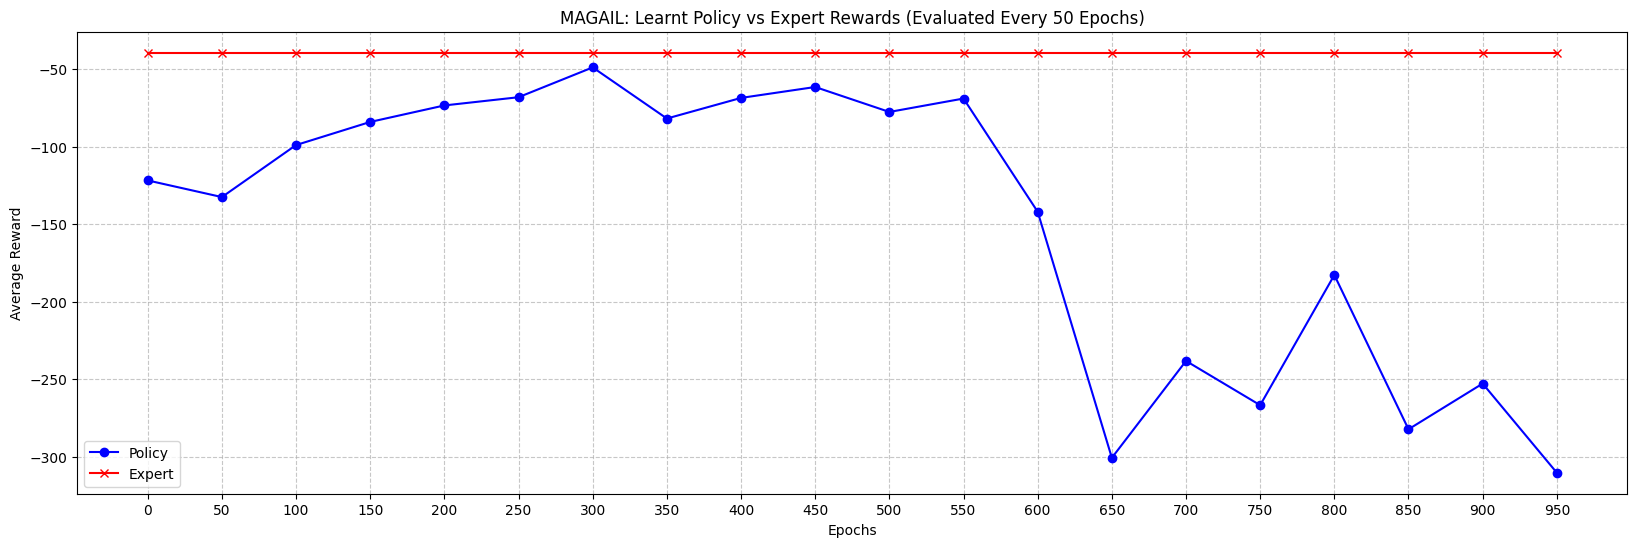

In [21]:
import os
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime


epochs = range(0, len(all_episode_rewards) * 50, 50)  # X-axis: epochs (0, 50, 100, ...)


# Create the plot
plt.figure(figsize=(20, 6))
plt.plot(epochs, all_episode_rewards, label='Policy', marker='o', color='blue')
plt.plot(epochs, all_expert_rewards, label='Expert', marker='x', color='red')

# Customize the plot
plt.xlabel('Epochs')
plt.ylabel('Average Reward')
plt.title('MAGAIL: Learnt Policy vs Expert Rewards (Evaluated Every 50 Epochs)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(epochs)  # Show epoch numbers on x-axis


# Save plot
os.makedirs("plots", exist_ok=True)
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
save_path = f"plots/magail_{timestamp}.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')


# Display the plot
plt.show()